# Interpolation, Extrapolation

In [ ]:
%reset -f

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [ ]:
%cd /gdrive/My\ Drive/2018_2019/temp


/gdrive/My Drive/2018_2019/temp


In [ ]:
import os
import shutil

import time
import numpy as np
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
import time
from IPython.display import Image
import time
import json
from keras.layers import Input, Concatenate, Dropout, BatchNormalization, Conv2D, UpSampling2D
np.set_printoptions(linewidth=300,precision=4,suppress=True)
plt.style.use("default")



In [ ]:
"changer pour ne pas écraser l'ancien"
DIR_FOR_TRAIN="train0"

if os.path.exists(DIR_FOR_TRAIN):
    shutil.rmtree(DIR_FOR_TRAIN)


"""création des dossiers """
os.makedirs(DIR_FOR_TRAIN)
os.makedirs(DIR_FOR_TRAIN + "/weights")
os.makedirs(DIR_FOR_TRAIN + "/fig")
os.makedirs(DIR_FOR_TRAIN + "/log")
    
    
"""taille des images"""
PATCH_DIM = 64


memo_train={}
memo_train["nb_points_for_training"]=400
memo_train["discont"]="no"
memo_train["PATCH_DIM"]=PATCH_DIM
batch_size = 40
memo_train["batch_size"]=batch_size



"""min et max des images, pour les imshow"""
if memo_train["discont"]=="additive":
    VMIN=-2.1
    VMAX=2.1
else:
    VMIN=-1.1
    VMAX=1.1

In [ ]:
%ls -R

.:
train0/

./train0:
fig/  log/  memo_train.json  weights/

./train0/fig:
0100.hat_y_test.png  1600.hat_y_test.png  losses0100.png  losses1600.png
0200.hat_y_test.png  1700.hat_y_test.png  losses0200.png  losses1700.png
0300.hat_y_test.png  1800.hat_y_test.png  losses0300.png  losses1800.png
0400.hat_y_test.png  1900.hat_y_test.png  losses0400.png  losses1900.png
0500.hat_y_test.png  2000.hat_y_test.png  losses0500.png  losses2000.png
0600.hat_y_test.png  2100.hat_y_test.png  losses0600.png  losses2100.png
0700.hat_y_test.png  2200.hat_y_test.png  losses0700.png  losses2200.png
0800.hat_y_test.png  2300.hat_y_test.png  losses0800.png  losses2300.png
0900.hat_y_test.png  2400.hat_y_test.png  losses0900.png  losses2400.png
1000.hat_y_test.png  2500.hat_y_test.png  losses1000.png  losses2500.png
1100.hat_y_test.png  2600.hat_y_test.png  losses1100.png  losses2600.png
1200.hat_y_test.png  2700.hat_y_test.png  losses1200.png  losses2700.png
1300.hat_y_test.png  2800.hat_y_test.png  losses1

## Générer les données

###  discontinuité

In [ ]:
def random_diag(a,b):
  
    angle=np.random.uniform(-np.pi/2,np.pi/2)
    pente=np.tan(angle)
    deb0=np.random.beta(3,3)
    deb1=np.random.beta(3,3)
    val0=np.random.uniform(0.5,1)
    val1=np.random.uniform(0.5,1)
    sign=np.random.randint(0,2)*2-1
    val0*=sign
    val1*=-sign
 
    return np.where(b<(a-deb0)*pente+deb1,val0,val1)

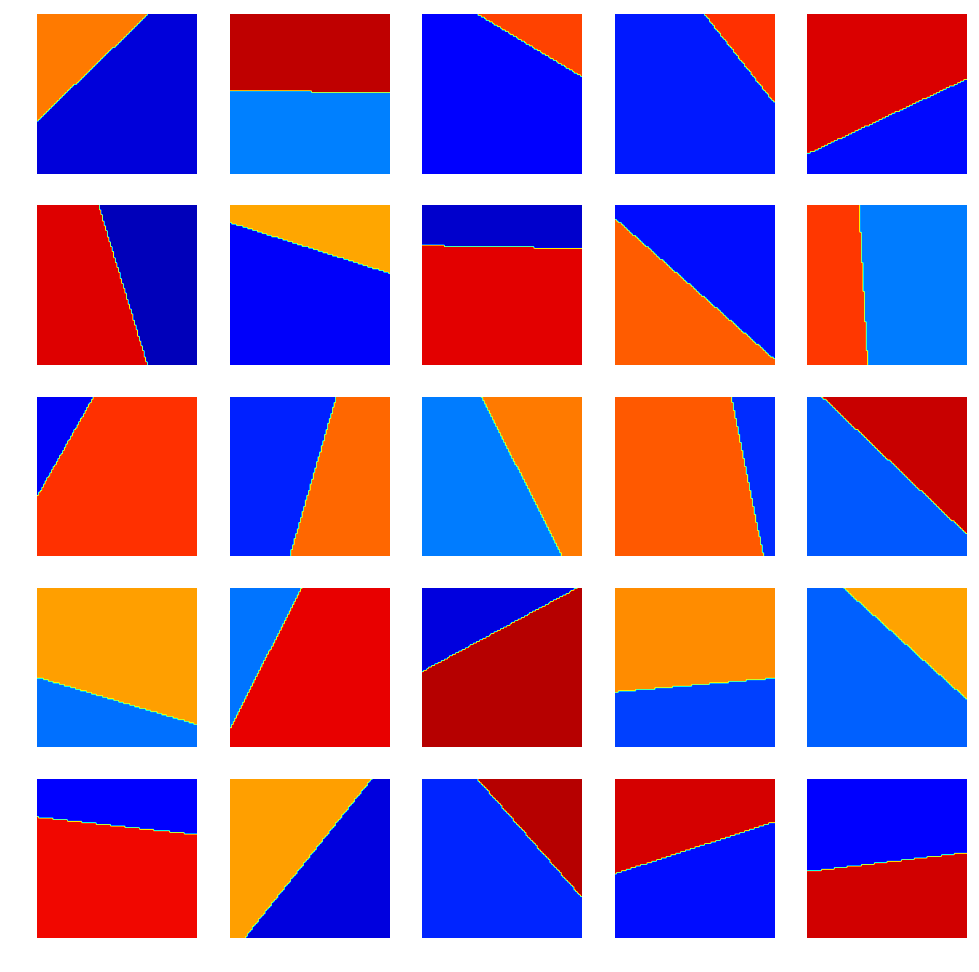

In [ ]:
a=np.linspace(0,1,100)
aa,bb=np.meshgrid(a,a)

fig,axs=plt.subplots(5,5,figsize=(12,12))
axs=axs.reshape(-1)

for ax in axs:
    ax.imshow(random_diag(aa,bb),cmap="jet",interpolation="bilinear",vmin=VMIN,vmax=VMAX);
    ax.axis("off")

### Déformations

In [ ]:
def ile_perturb(a,b,ca,cb,da,db):

    per0=np.sin(2*np.pi*a*da)
    per1=np.sin(2*np.pi*b*db)

    a_=a+ca*per0
    b_=b+cb*per0*per1

    y=np.sin(20*a_)*np.sin(20*b_)
    return y

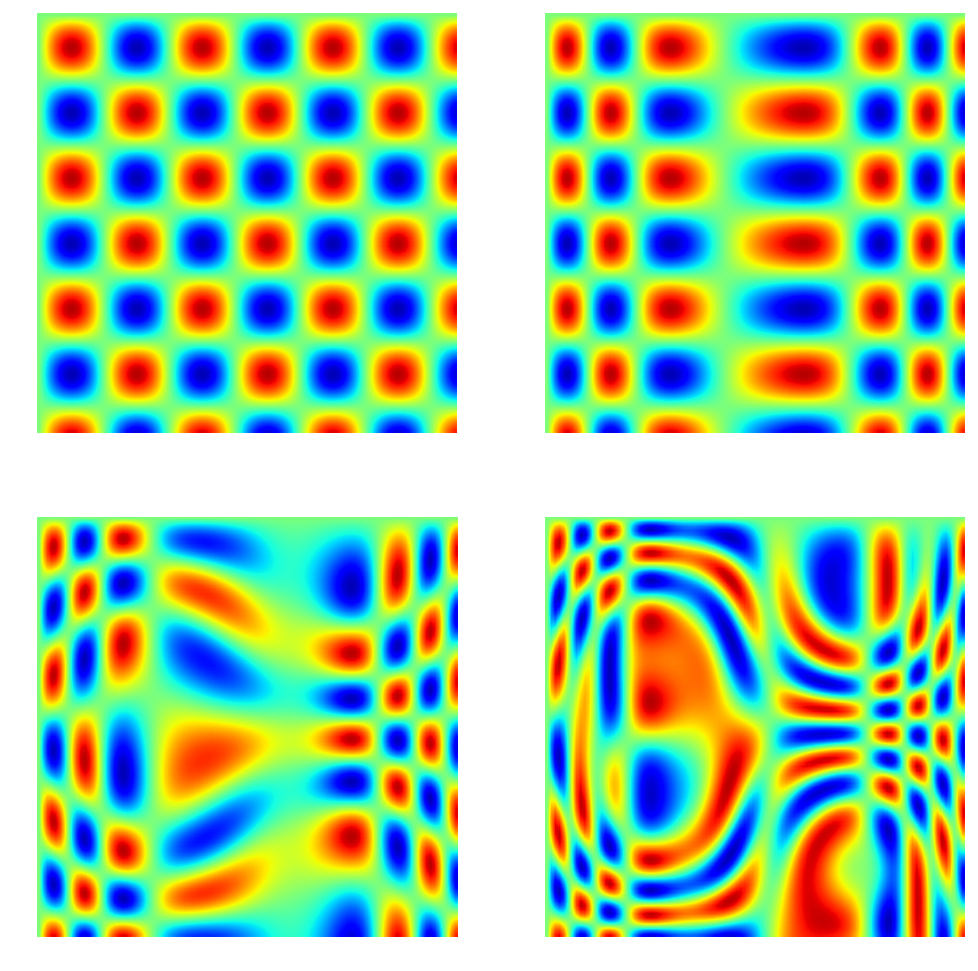

In [ ]:
a=np.linspace(0,1,100)
aa,bb=np.meshgrid(a,a)

ca=[0,0.1,0.2,0.3]
cb=[0,0. ,0.1,0.3]

fig,axs=plt.subplots(2,2,figsize=(12,12))
axs=axs.reshape(-1)

for i,ax in enumerate(axs):
    ax.imshow(ile_perturb(aa,bb,ca[i],cb[i],1,1),cmap="jet",interpolation="bilinear",vmin=VMIN,vmax=VMAX);
    ax.axis("off")

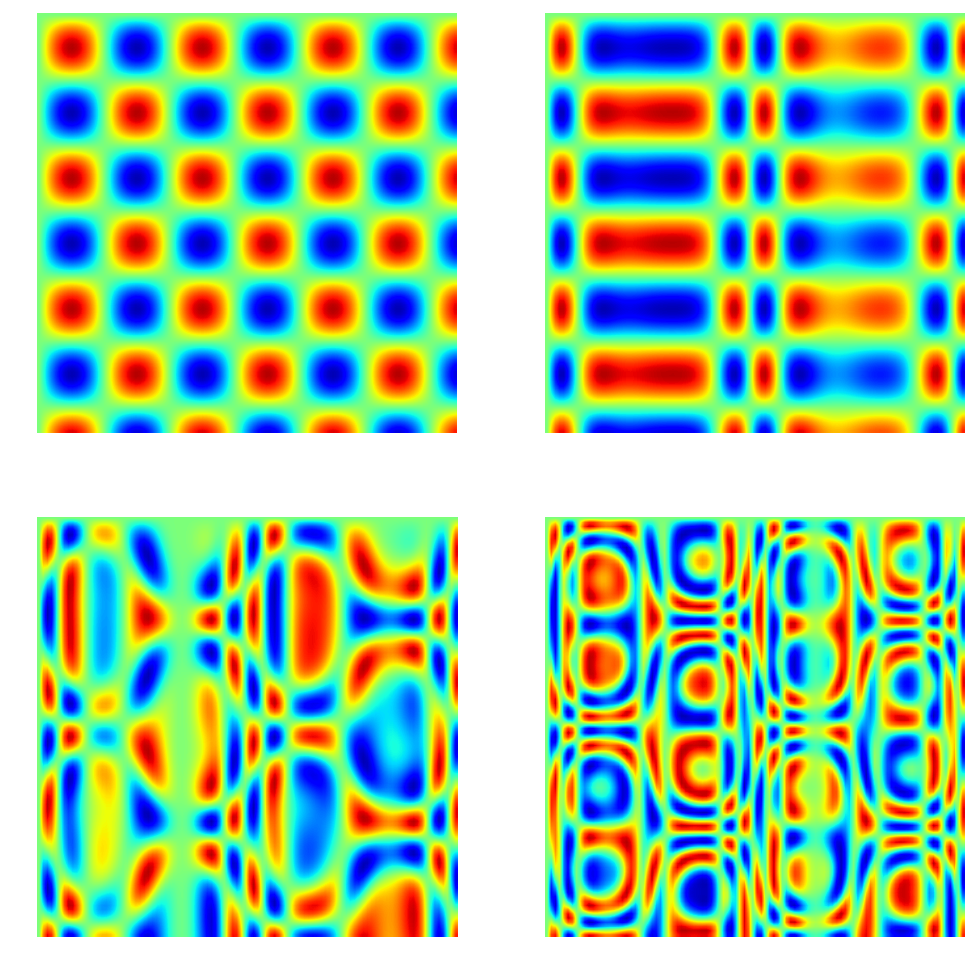

In [ ]:
fig,axs=plt.subplots(2,2,figsize=(12,12))
axs=axs.reshape(-1)

for i,ax in enumerate(axs):
    ax.imshow(ile_perturb(aa,bb,ca[i],cb[i],2,2),cmap="jet",interpolation="bilinear",vmin=VMIN,vmax=VMAX);
    ax.axis("off")

### Iles aléatoires

In [ ]:
class DataParam:
  
    def __init__(self):

        self.seed=None # fixe la graine du générateur
        self.freqs=(1,6) # le nombre d'ile dans une largeur (=une hauteur). Défaut: entre 1 et 6 
        self.perturbs=(0.02,0.4) # intensité des déformations. Défaut; entre 0.02 et 0.4
        self.discont="no" # choix no, additive, multiplicative

In [ ]:
dataParam=DataParam()
dataParam.__dict__

{'discont': 'no', 'freqs': (1, 6), 'perturbs': (0.02, 0.4), 'seed': None}

In [ ]:
memo_train["dataParam"]=dataParam.__dict__
memo_train

{'PATCH_DIM': 64,
 'batch_size': 40,
 'dataParam': {'discont': 'no',
  'freqs': (1, 6),
  'perturbs': (0.02, 0.4),
  'seed': None},
 'discont': 'no',
 'nb_points_for_training': 400}

In [ ]:
def ile_aleatoire(a,b,dataParam):
   
    nu=np.random.uniform(dataParam.freqs[0],dataParam.freqs[1],size=2)
    per_coef=np.random.uniform(dataParam.perturbs[0],dataParam.perturbs[1],size=2)

    per0=np.sin(2*np.pi*a)
    per1=np.sin(2*np.pi*b)

    a_=a+per_coef[0]*per0
    b_=b+per_coef[1]*per0*per1

    y=np.sin(np.pi*nu[0]*a_)*np.sin(np.pi*nu[1]*b_)


    if dataParam.discont=="multiplicative":
        y*=random_diag(a,b)
    elif dataParam.discont=="additive":
        y+=random_diag(a,b)

    return y        

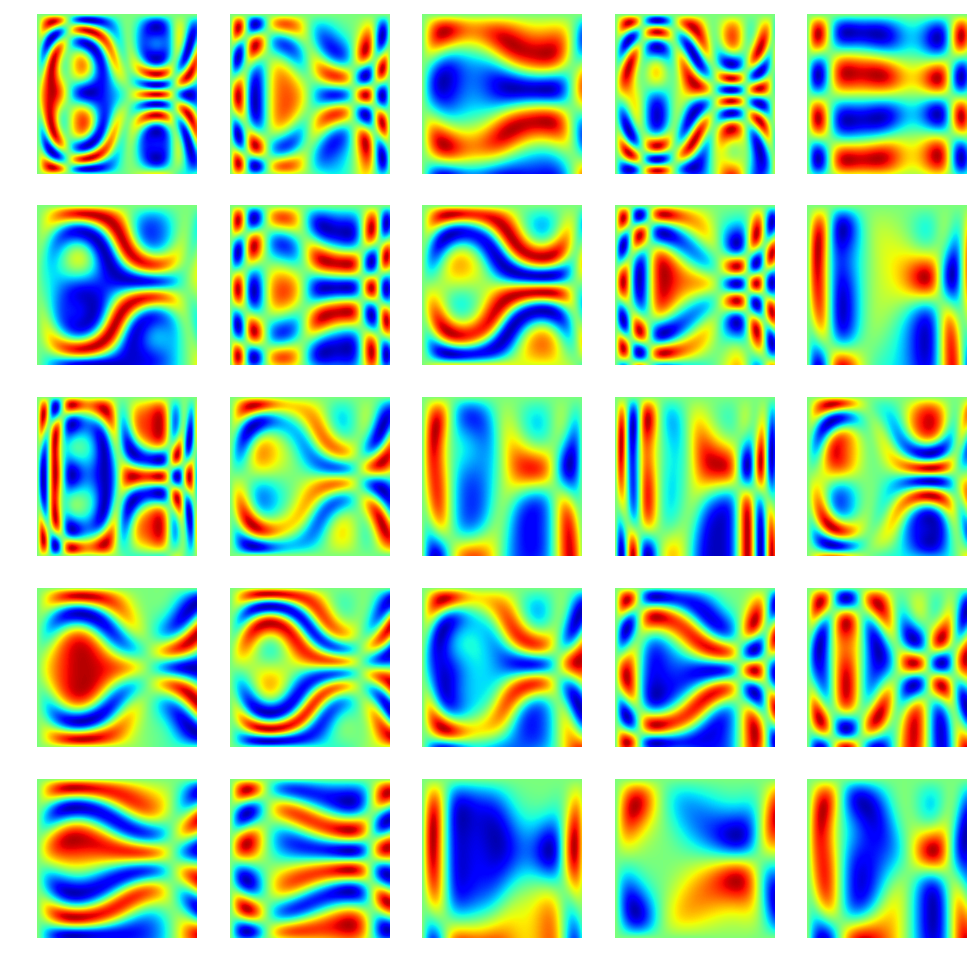

In [ ]:
a=np.linspace(0,1,100)
aa,bb=np.meshgrid(a,a)

fig,axs=plt.subplots(5,5,figsize=(12,12))
axs=axs.reshape(-1)

for ax in axs:
    ax.imshow(ile_aleatoire(aa,bb,dataParam),cmap="jet",interpolation="bilinear",vmin=VMIN,vmax=VMAX);
    ax.axis("off")

### Points sur iles

In [ ]:
def dataGenerator_points_sur_ile(batch_size,nb_points,dataParam,returnPoints):


    def oneBatch():
        a=np.linspace(0,1,PATCH_DIM,dtype=np.float32)
        aa,bb=np.meshgrid(a,a)
        z=np.empty([batch_size,PATCH_DIM,PATCH_DIM,1])
        for i in range(batch_size):
            z[i,:,:,0]=ile_aleatoire(aa,bb,dataParam)
        return z


    if dataParam.seed is not None: 
        np.random.seed(dataParam.seed)

    while True:

        Y=oneBatch()
        X=np.zeros_like(Y)

        points=np.random.randint(0,PATCH_DIM,size=(batch_size,nb_points,2))
        for b in range(batch_size):
            i=points[b,:,0]
            j=points[b,:,1]                       
            X[b,i,j,:]=Y[b,i,j,:]

        if returnPoints:
            yield X,Y,points
        else:
            yield X,Y

In [ ]:
for X,Y,points in dataGenerator_points_sur_ile(6,memo_train["nb_points_for_training"],dataParam,returnPoints=True):
    break
 

In [ ]:
print(X.shape,Y.shape,points.shape)

(6, 64, 64, 1) (6, 64, 64, 1) (6, 400, 2)


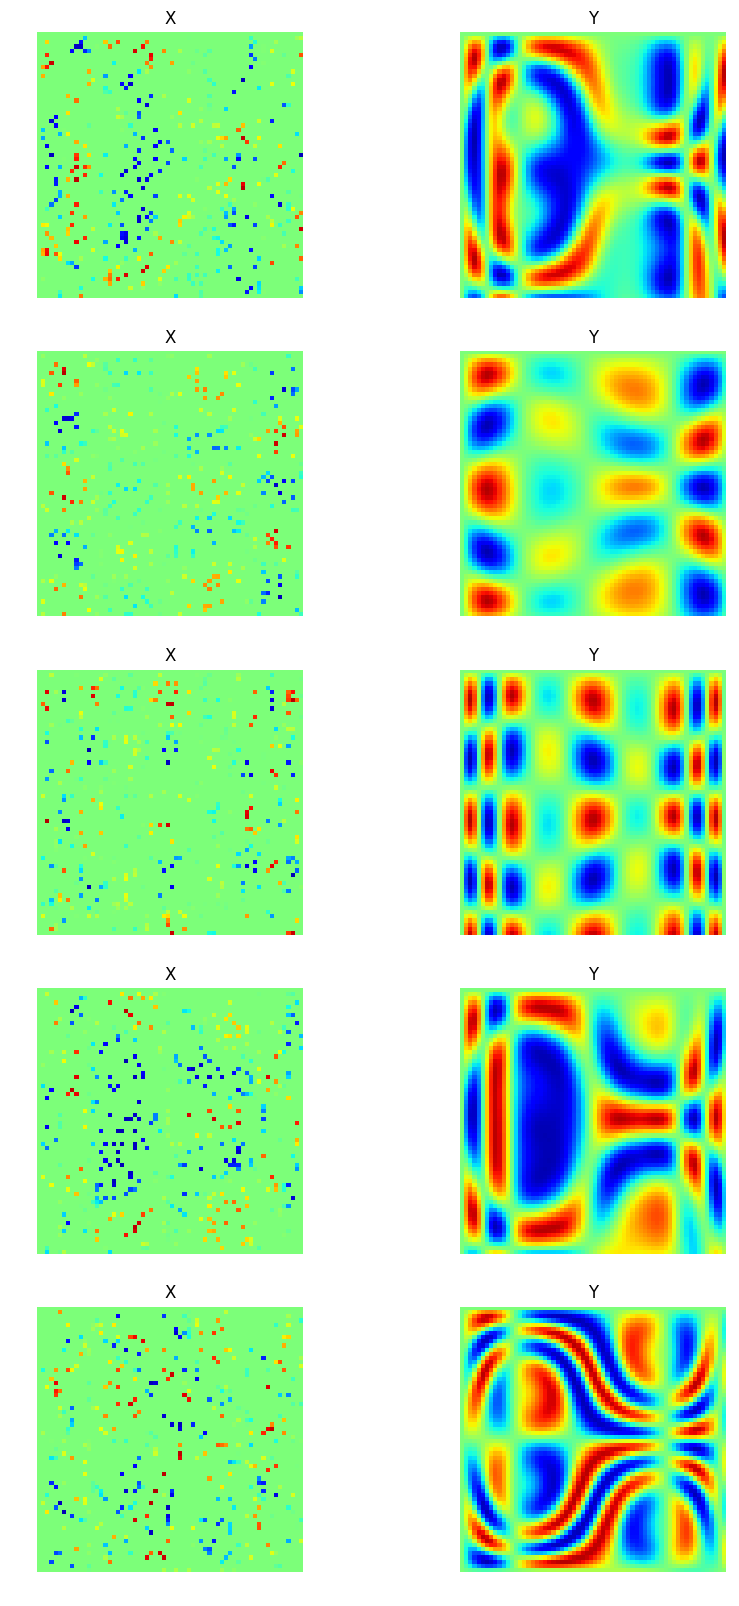

In [ ]:
"maintenant on utilise interpolation='nearest' pour montrer la résolution des images "
def oneGraph(ax,A):
    ax.imshow(A[:,:],cmap="jet",vmin=VMIN, vmax=VMAX,interpolation="nearest")
    ax.axis("off")

nb=5
fig=plt.figure()
axs=fig.subplots(nb,2)
fig.set_size_inches(10,nb*4)


for i in range(nb):
    ax=axs[i,0]
    oneGraph(ax,X[i,:,:,0])
    ax.set_title("X")

    ax=axs[i,1]
    oneGraph(ax,Y[i,:,:,0])
    ax.set_title("Y")

  

### Reproductibilité

In [ ]:
dataParam.seed=13
for X,Y,points in dataGenerator_points_sur_ile(6,memo_train["nb_points_for_training"],dataParam,returnPoints=True):
    break
for X_,Y_,points_ in dataGenerator_points_sur_ile(6,memo_train["nb_points_for_training"],dataParam,returnPoints=True):
    break
    
dataParam.seed=None  

In [ ]:
print(np.sum(X-X_))
print(np.sum(Y-Y_))

0.0
0.0


## Modèle

### Définition du modèle lui même

In [ ]:
class Model_interpolation_2D:

    def __init__(self,patch_size:int,dropout:float):

        self.patch_size = patch_size
        self.dropout=dropout

    def __call__(self,X):

        print("X.get_shape():",X.get_shape())

        deph = 16
        Y=X

        """ (s,s,d*2)  """
        Y = Conv2D(deph*2 , 5, activation='relu', padding='same', kernel_initializer='he_normal')(Y)
        Y = Conv2D(deph*2, 5, activation='relu', padding='same', kernel_initializer='he_normal')(Y)
        Y = BatchNormalization()(Y)
        Y = Dropout(self.dropout)(Y)
        jump1= Y = Dropout(self.dropout,name="jump1")(Y)


        """ (s/2,s/2,d*4) """
        Y = Conv2D(deph * 4, 2, activation='relu', padding='same', kernel_initializer='he_normal',strides=(2, 2))(Y)
        Y = Conv2D(deph * 4, 5, activation='relu', padding='same', kernel_initializer='he_normal')(Y)
        Y = BatchNormalization()(Y)
        Y = Dropout(self.dropout)(Y)
        jump2=Y = Conv2D(deph * 2, 5, activation='relu', padding='same', kernel_initializer='he_normal',name="jump2")(Y)


        """ (s/4,s/4,d*8)  """
        Y = Conv2D(deph * 8, 2, activation='relu', padding='same', kernel_initializer='he_normal',strides=(2, 2))(Y)
        Y = Conv2D(deph * 8, 5, activation='relu', padding='same', kernel_initializer='he_normal')(Y)
        Y = BatchNormalization()(Y)
        Y = Dropout(self.dropout,name="bottle_neck")(Y)


        """ (s/2,s/2)   d*8 -> d*8+d*4 -> d*4 """
        Y = Conv2D(deph * 8, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=2)(Y))
        Y = Concatenate()([jump2, Y])
        Y = Conv2D(deph * 4, 5, activation='relu', padding='same', kernel_initializer='he_normal')(Y)
        Y = Conv2D(deph * 4, 5, activation='relu', padding='same', kernel_initializer='he_normal')(Y)
        Y = Dropout(self.dropout)(Y)


        """ (s,s)   d*4 -> d*4+d*2-> d*2 """
        Y = Conv2D(deph * 4, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=2)(Y))
        Y = Concatenate()([jump1, Y])
        Y = Conv2D(deph * 4, 5, activation='relu', padding='same', kernel_initializer='he_normal')(Y)
        Y = Conv2D(deph * 2, 5, activation='relu', padding='same', kernel_initializer='he_normal')(Y)
        Y = BatchNormalization()(Y)
        Y = Dropout(self.dropout)(Y)


        Y = Conv2D(1, 1)(Y)

        return Y

In [ ]:
def print_model():

    input = keras.Input(batch_shape=(None, PATCH_DIM, PATCH_DIM, 1))
    output = Model_interpolation_2D(PATCH_DIM, dropout=1)(input)
    model = keras.Model(inputs=input, outputs=output)
    model.summary()
    
print_model()

X.get_shape(): (?, 64, 64, 1)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 64, 64, 32)   832         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 64, 64, 32)   25632       conv2d_14[0][0]                  
__________________________________________________________________________________________________
batch_normalization_5 (BatchNor (None, 64, 64, 32)   128         conv2d_15[0][0]                  
_______________________________________________________________________________

### Loss

In [ ]:
def quadratic_loss(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=[-1])
    y_pred = tf.reshape(y_pred, shape=[-1])
    return tf.reduce_mean((y_true - y_pred) ** 2)


def absolute_loss(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=[-1])
    y_pred = tf.reshape(y_pred, shape=[-1])
    return tf.reduce_mean(tf.abs(y_true - y_pred))

### Callback

In [ ]:
#pour eviter d'ouvrir plein de figures, on crée un objet global
fig=plt.figure(1)

def validation_graphic(X,Y,hat_Y,nb,path=None):

    assert nb<=X.shape[0], "pas assez de données"

    def oneGraph(ax,A):
        ax.imshow(A[:,:],cmap="jet",vmin=VMIN, vmax=VMAX,interpolation="nearest")
        ax.axis("off")


    axs=fig.subplots(nb,3)
    fig.set_size_inches(10,nb*4)

    for i in range(nb):
        ax=axs[i,0]
        oneGraph(ax,X[i,:,:,0])
        ax.set_title("X")

        ax=axs[i,1]
        oneGraph(ax,Y[i,:,:,0])
        ax.set_title("Y")

        ax=axs[i,2]
        oneGraph(ax,hat_Y[i,:,:,0])
        ax.set_title("hatY")


    if path is not None:
        fig.savefig(path)

    fig.clear();



class MyCallback(keras.callbacks.Callback):
  
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses=[]
        self.itr=0
        self.itrs_epoch=[]
        self.itrs=[]

    def on_train_end(self, logs={}):
        return

    def on_epoch_begin(self, epoch, logs={}):
        return

    def on_epoch_end(self, epoch, logs={}):
      
       
        self.itrs_epoch.append(self.itr)
        "on trace la loss en échelle logarithmique"
        self.val_losses.append(np.log(logs.get('val_loss')))
       
        
        ax=fig.subplots()
        ax.plot(self.itrs,self.losses)
        ax.plot(self.itrs_epoch,self.val_losses,"o")
        
        fig.savefig(DIR_FOR_TRAIN+"/fig/losses%04d.png"%self.itr)
        fig.clear()
        
        nb=3
        
        for X, Y in dataGenerator_points_sur_ile(nb,memo_train["nb_points_for_training"],dataParam,returnPoints=False):
            break
        hat_Y = self.model.predict(X)#batch_size=nb
                
        path=DIR_FOR_TRAIN + "/fig/%04d.hat_y_test.png"%self.itr
        validation_graphic(X,Y,hat_Y,nb,path=path)

        

    def on_batch_begin(self, batch, logs={}):
        return

    def on_batch_end(self, batch, logs={}):
        self.losses.append(np.log(logs.get('loss')))
        self.itrs.append(self.itr)
        self.itr+=1

        

In [ ]:
def modelCheckPoint():
    return keras.callbacks.ModelCheckpoint(
              filepath=DIR_FOR_TRAIN + '/weights/Vnet3couches-{epoch:02d}-{loss:.4f}.h5',
              monitor='loss',  # ou monitor='val_loss'
              verbose=0,
              save_best_only=True)
  

## Entrainement et validation

### Créer  le modèle

In [ ]:
def make_model():
    input= keras.Input(batch_shape=(None,PATCH_DIM,PATCH_DIM, 1))
    output=Model_interpolation_2D(PATCH_DIM,dropout=1)(input)
    model = keras.Model(inputs=input, outputs=output)
    model.compile(optimizer=keras.optimizers.Adam(lr=0.001), loss=quadratic_loss, metrics=[absolute_loss])
    return model

In [ ]:
memo_train["model"]="Vnet_3layers"
model=make_model()

X.get_shape(): (?, 64, 64, 1)


### L'entrainement, c'est parti

In [ ]:
time_deb=time.time()
starting_time = time.time()

generator_train = dataGenerator_points_sur_ile(batch_size,memo_train["nb_points_for_training"],dataParam,returnPoints=False)
generator_validation = dataGenerator_points_sur_ile(batch_size,memo_train["nb_points_for_training"],dataParam,returnPoints=False)

print('Fitting model...')

memo_train["steps_per_epoch"]=100
memo_train["validation_steps"]=5
memo_train["epochs"]=30
try:
    model.fit_generator(
        generator=generator_train,
        steps_per_epoch=memo_train["steps_per_epoch"],
        epochs=memo_train["epochs"],
        callbacks=[MyCallback(),modelCheckPoint()],
        validation_data=generator_validation,
        validation_steps=memo_train["validation_steps"]
    )

    
except  KeyboardInterrupt:
    print("on a stoppé")
    
    
duration=time.time()-time_deb

memo_train["training_duration"]=duration




In [ ]:
with open(DIR_FOR_TRAIN+'/memo_train.json', 'w') as fp:
    json.dump(memo_train, fp)

## TEST 

In [ ]:
"changer pour ne pas écraser l'ancien"
DIR_FOR_TEST="test0"

"""création des dossiers """
os.makedirs(DIR_FOR_TEST)


### Recuperation d'un modèle 

In [ ]:
%ls train0/weights

Vnet3couches-01-0.1354.h5  Vnet3couches-11-0.0076.h5  Vnet3couches-22-0.0043.h5
Vnet3couches-02-0.0430.h5  Vnet3couches-12-0.0074.h5  Vnet3couches-23-0.0042.h5
Vnet3couches-03-0.0275.h5  Vnet3couches-13-0.0066.h5  Vnet3couches-24-0.0041.h5
Vnet3couches-04-0.0191.h5  Vnet3couches-14-0.0063.h5  Vnet3couches-25-0.0040.h5
Vnet3couches-05-0.0155.h5  Vnet3couches-15-0.0060.h5  Vnet3couches-26-0.0037.h5
Vnet3couches-06-0.0132.h5  Vnet3couches-16-0.0058.h5  Vnet3couches-27-0.0036.h5
Vnet3couches-07-0.0113.h5  Vnet3couches-17-0.0055.h5  Vnet3couches-28-0.0035.h5
Vnet3couches-08-0.0102.h5  Vnet3couches-18-0.0053.h5  Vnet3couches-30-0.0033.h5
Vnet3couches-09-0.0090.h5  Vnet3couches-19-0.0049.h5
Vnet3couches-10-0.0087.h5  Vnet3couches-21-0.0045.h5


In [ ]:
"mettre ici le chemin d'accès au fichier .h5 contenant les weiths du modèle entrainé"
file_path="train0/weights/Vnet3couches-30-0.0033.h5"
model=keras.models.load_model(file_path, custom_objects={"quadratic_loss": quadratic_loss, "absolute_loss": absolute_loss})

### Paramètrage du test

In [ ]:
memo_test={}

dataParam_test=DataParam()
"important, régler la plage de fréquences"
dataParam_test.freqs=(5,6)
memo_test["dataParam"]=dataParam_test.__dict__

"le nombre de points (pas forcément équal à celui de l'apprentissage)"
memo_test["points"]=400
"on ne change pas le batch_size"
memo_test["batch_size"]=batch_size

In [ ]:
"attention, le temps n'est pas très stable. Environ 0.1 seconde"
for X,Y,points in dataGenerator_points_sur_ile(batch_size,memo_test["points"],dataParam_test,returnPoints=True):
    time_deb=time.time()
    hat_Y=model.predict(X)
    dur=time.time()-time_deb
    print("duration",dur)
    memo_test["predict_duration"]=round(dur,4)
    break
  

duration 0.10812973976135254


In [ ]:
print(X.shape,Y.shape,hat_Y.shape,points.shape)

(40, 64, 64, 1) (40, 64, 64, 1) (40, 64, 64, 1) (40, 400, 2)


### Calcul de l'erreur

In [ ]:
"on ne calcule l'erreur qu'à l'intérieure de l'image"
" car sur les bords, les splins ne fonctionnent pas"
memo_test["margin"]=15

def compute_errors(Y,Y_approx):

    margin=memo_test["margin"]
    def make_mean(Z):
        restricted=Z[:,margin:-margin,margin:-margin,0]
        res=np.sum(restricted,axis=1)
        res=np.sum(res,axis=1)
        res/= restricted.shape[1]*restricted.shape[2]
        return res

    diff=Y-Y_approx
    diff_sqr=diff**2
    diff_abs=np.abs(diff)
    rmse=np.sqrt(make_mean(diff_sqr))
    mae=make_mean(diff_abs)

    return rmse,mae

In [ ]:
rmse,mae=compute_errors(Y,hat_Y)
print(rmse.shape,mae.shape)

(40,) (40,)


In [ ]:
rmse,mae

(array([0.0594, 0.0594, 0.0401, 0.0754, 0.0349, 0.0362, 0.0815, 0.0722, 0.0465, 0.0414, 0.0791, 0.1017, 0.0839, 0.0837, 0.0438, 0.0478, 0.0722, 0.0585, 0.0481, 0.0717, 0.0961, 0.0321, 0.0936, 0.0692, 0.0822, 0.0476, 0.043 , 0.0895, 0.0846, 0.0593, 0.0696, 0.0363, 0.0682, 0.0755, 0.0269, 0.0865,
        0.1226, 0.066 , 0.0734, 0.0362]),
 array([0.0453, 0.0441, 0.0316, 0.0528, 0.0268, 0.0268, 0.0611, 0.0499, 0.0334, 0.0319, 0.0624, 0.0751, 0.0645, 0.0584, 0.0342, 0.0368, 0.056 , 0.0458, 0.0372, 0.0537, 0.0708, 0.023 , 0.0612, 0.0505, 0.0619, 0.0362, 0.0301, 0.0667, 0.0626, 0.0454, 0.0534, 0.0266, 0.0517, 0.0549, 0.0198, 0.0669,
        0.0859, 0.0489, 0.0544, 0.0293]))

### calcul des splins

In [ ]:
a=np.linspace(0,1,PATCH_DIM,dtype=np.float32)
aa,bb=np.meshgrid(a,a)

values=np.empty(shape=[batch_size,memo_test["points"]])

for b in range(batch_size):
    i=points[b,:,0]
    j=points[b,:,1]                       
    values[b,:]=Y[b,i,j,0]

values.shape


(40, 400)

In [ ]:
points_float=points/PATCH_DIM
points_float[0,:10,:]

array([[0.4375, 0.6562],
       [0.8594, 0.9219],
       [0.2344, 0.    ],
       [0.2812, 0.125 ],
       [0.0469, 0.5   ],
       [0.2969, 0.5   ],
       [0.5781, 0.0156],
       [0.6875, 0.0938],
       [0.4062, 0.2188],
       [0.2812, 0.4688]])

In [ ]:
values[0,:10]

array([-0.0026,  0.1231, -0.    , -0.4377,  0.6691, -0.9935, -0.0476,  0.2636,  0.6617, -0.8086])

In [ ]:
from scipy.interpolate import griddata

a=np.linspace(0,1,PATCH_DIM,dtype=np.float32)
aa,bb=np.meshgrid(a,a)

grid_z2 = griddata(points_float[0], values[0], (aa, bb), method='cubic',fill_value=0)

(-0.5, 63.5, 63.5, -0.5)

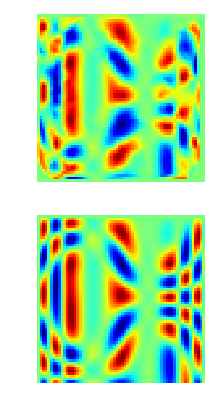

In [ ]:
fig,(ax0,ax1)=plt.subplots(2,1)

ax0.imshow(grid_z2.T,cmap="jet")
ax0.axis("off")
ax1.imshow(Y[0,:,:,0],cmap="jet")
ax1.axis("off")

Les splints cubic prennet 4 à 5 fois plus de temps

In [ ]:
X_splin=np.empty(shape=(values.shape[0],PATCH_DIM,PATCH_DIM,1))
time_deb=time.time()
for b in range(values.shape[0]):
    X_splin[b,:,:,0]=griddata(points_float[b], values[b], (aa, bb), method='cubic',fill_value=0).T

dur=time.time()-time_deb
print(dur)
memo_test["splin_duration"]=round(dur,4)

0.42113780975341797


### comparaison graphique et numérique

In [ ]:

def test_graphic(X,Y,hat_Y,X_splin,nb):
  
    assert nb<=X.shape[0], "pas assez d'images dans X"

    def oneGraph(ax,A):
        ax.imshow(A[:,:],cmap="jet",vmin=VMIN, vmax=VMAX,interpolation="nearest")
        ax.axis("off")


    rmse,mae=compute_errors(Y,hat_Y)
    rmse_splin,mae_splin=compute_errors(Y,X_splin)


    fig,axs=plt.subplots(nb,4,figsize=(4*5,nb*5))

    fig.suptitle(str(memo_test))

    for i in range(nb):
        ax=axs[i,0]
        oneGraph(ax,X[i,:,:,0])
        ax.set_title("X")

        ax=axs[i,1]
        oneGraph(ax,Y[i,:,:,0])
        ax.set_title("Y")


        ax=axs[i,2]
        oneGraph(ax,hat_Y[i,:,:,0])
        ax.set_title("hatY \n  mae: %.3f \n rmse: %.3f"%(mae[i],rmse[i]))


        ax=axs[i,3]
        oneGraph(ax,X_splin[i,:,:,0])
        ax.set_title("X_splin \n  mae: %.3f \n rmse: %.3f"%(mae_splin[i],rmse_splin[i]))


    fig.savefig(DIR_FOR_TEST+"/"+str(memo_test)+".png")
    
    
  


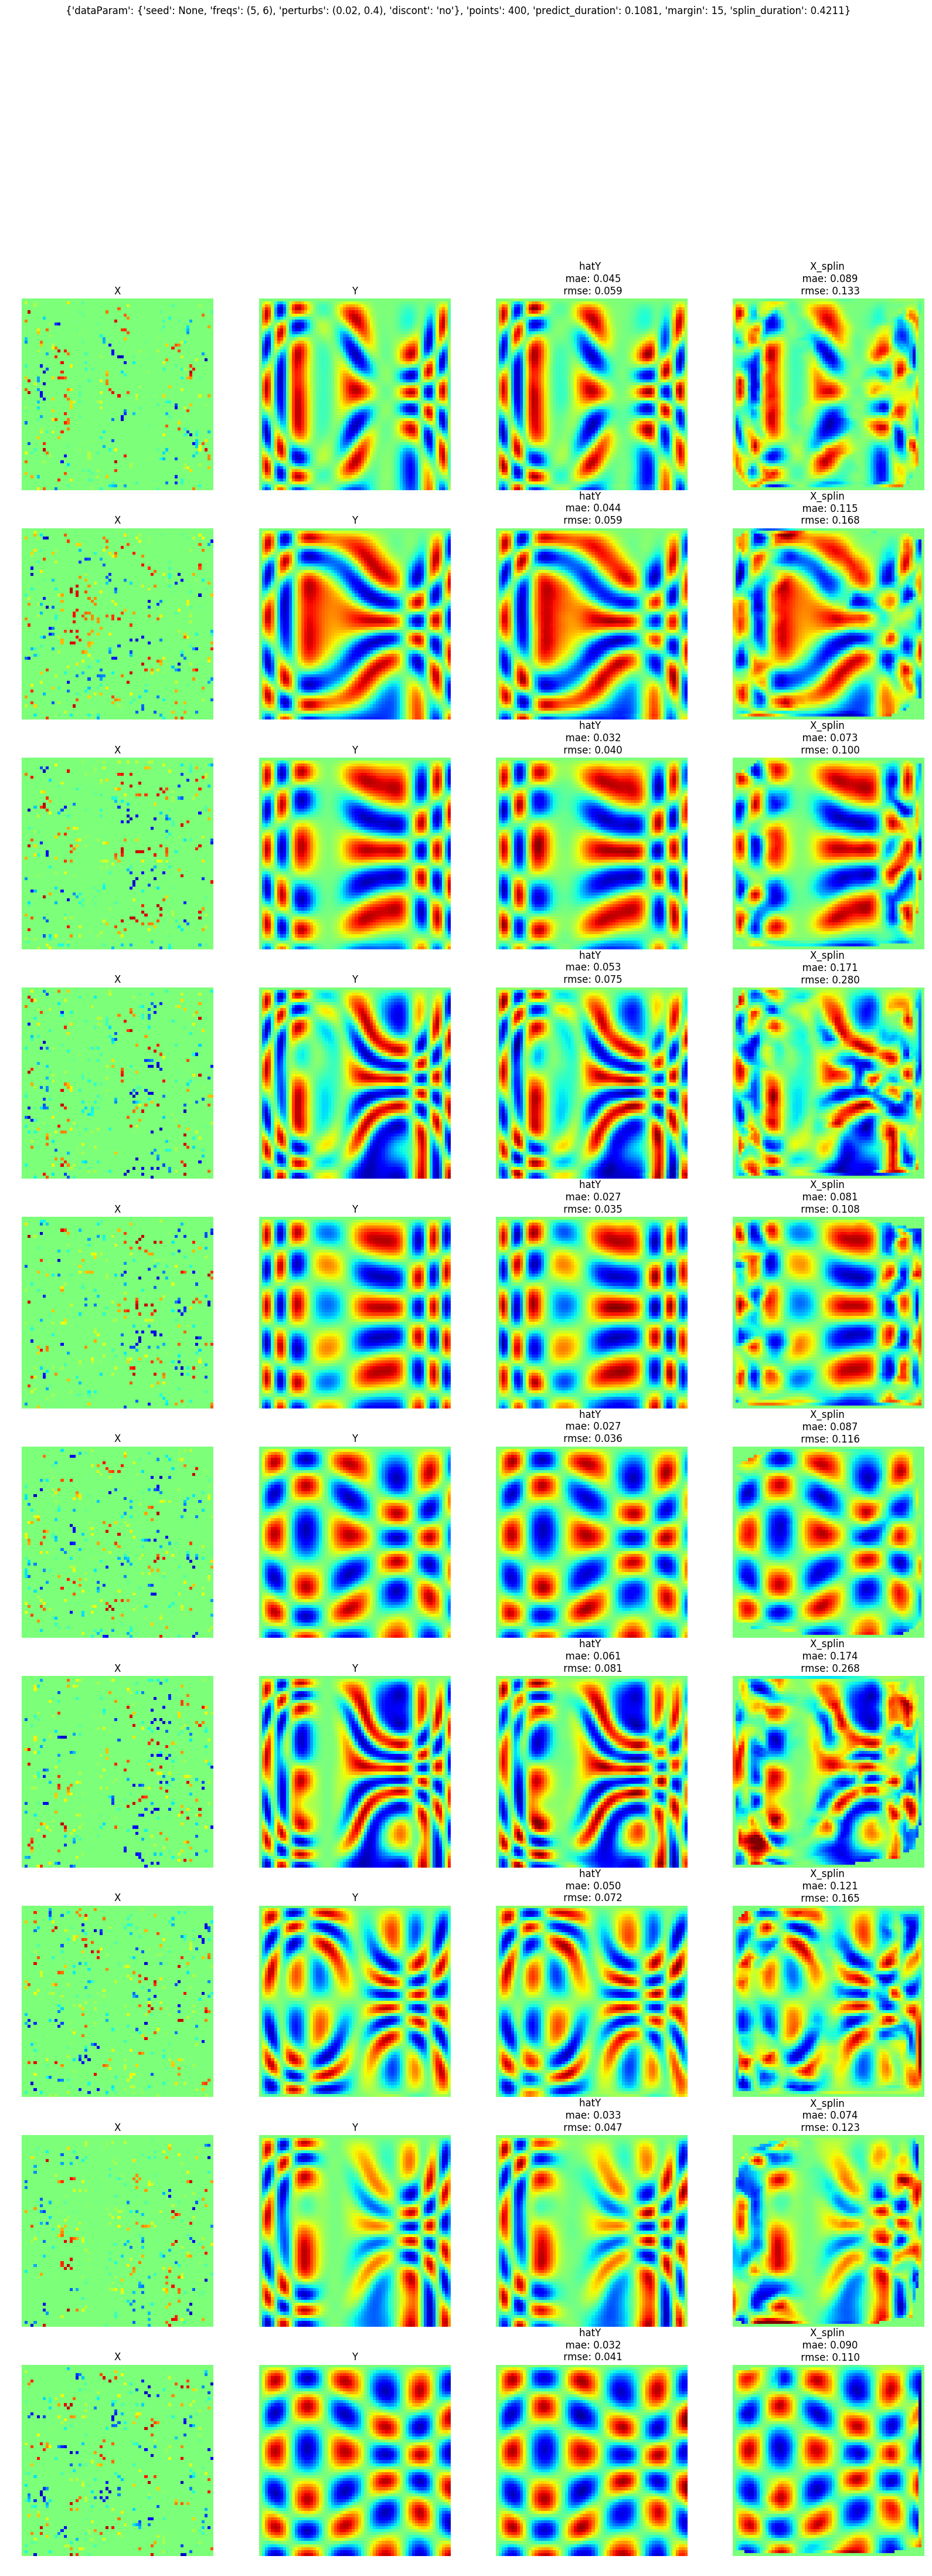

In [ ]:
test_graphic(X,Y,hat_Y,X_splin,10)